In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [2]:
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
df =pd.read_csv('PJME_hourly.csv')

In [4]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [5]:
df = df.set_index('Datetime')

In [6]:
df.index = pd.to_datetime(df.index)

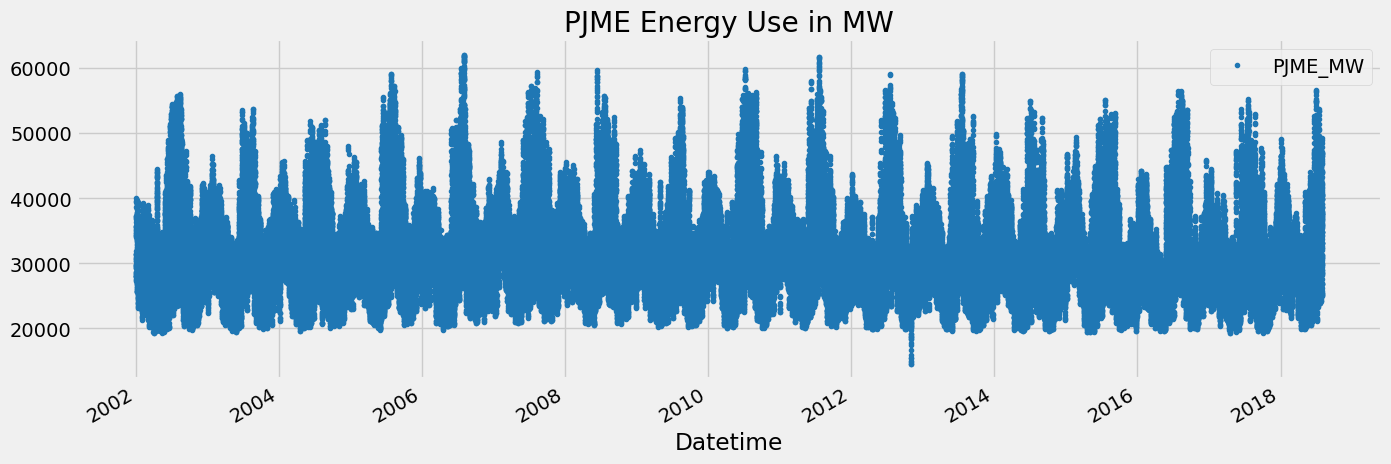

In [7]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

### Train Test Split

In [8]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index  >= '01-01-2015']

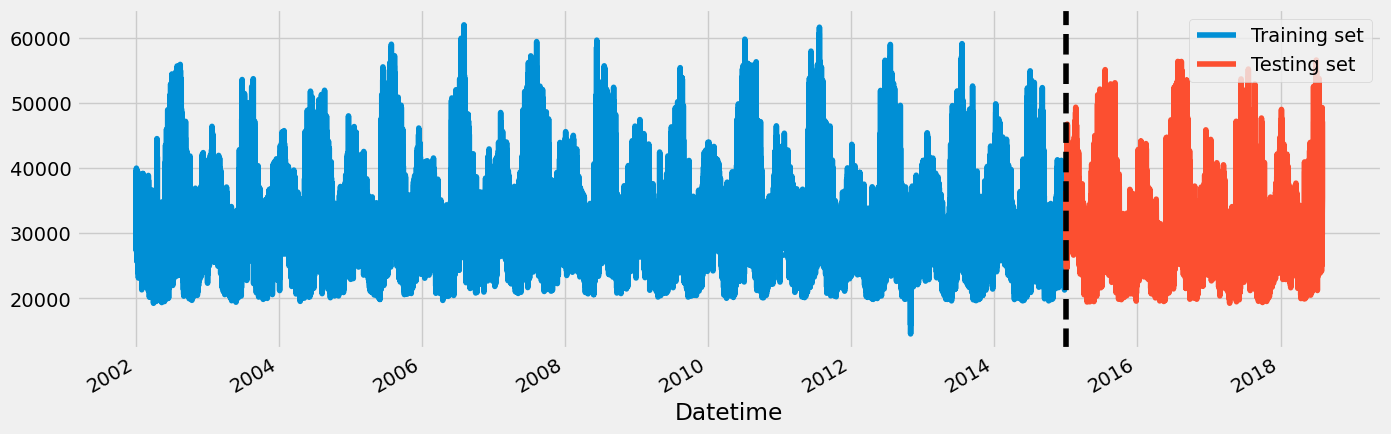

In [9]:
fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax = ax,  label = 'Training Set')
test.plot(ax = ax, label = 'Test Set')
ax.axvline('01-01-2015', color = 'black' ,  ls = '--')
ax.legend(['Training set' , 'Testing set'])
plt.show()

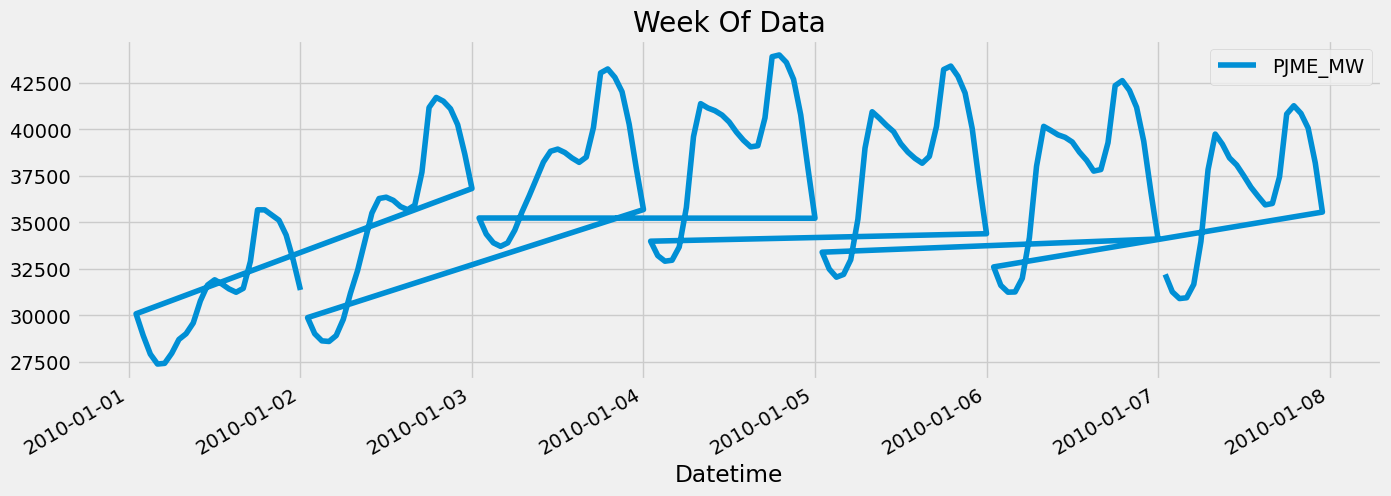

In [10]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

### Freature Creation

In [11]:
def create_features(df):
    df['hour'] = df.index.hour
    df['week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [12]:
df = create_features(df)

### Visualise our eatures / Target REaltionship

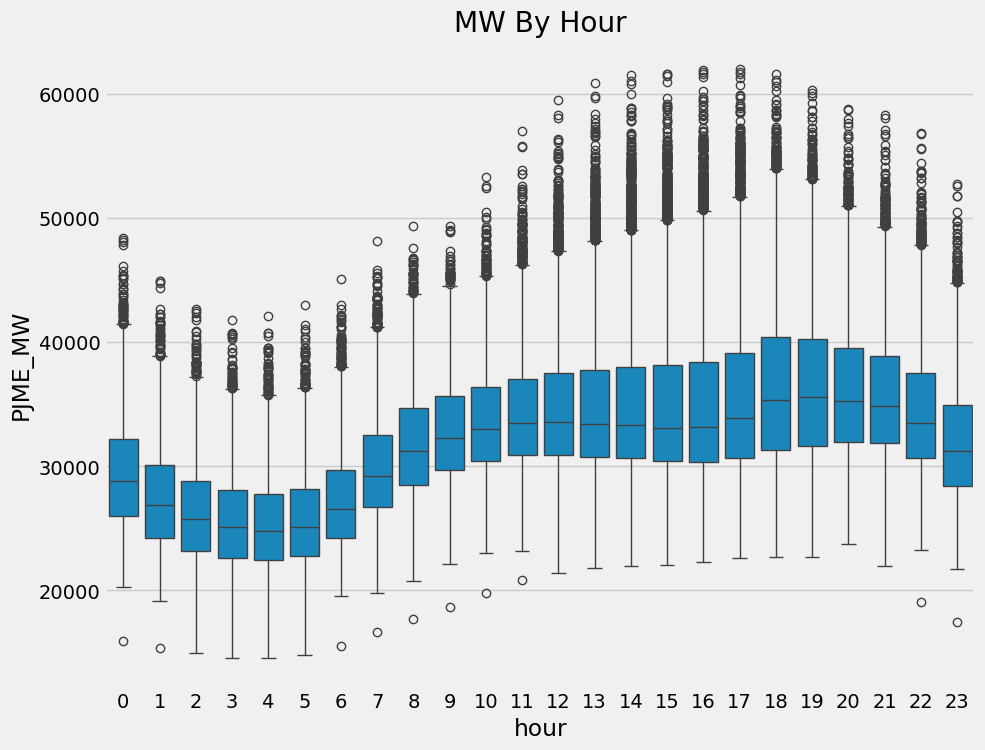

In [13]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.boxplot(data = df, x = 'hour' , y = 'PJME_MW')
ax.set_title('MW By Hour')
plt.show()

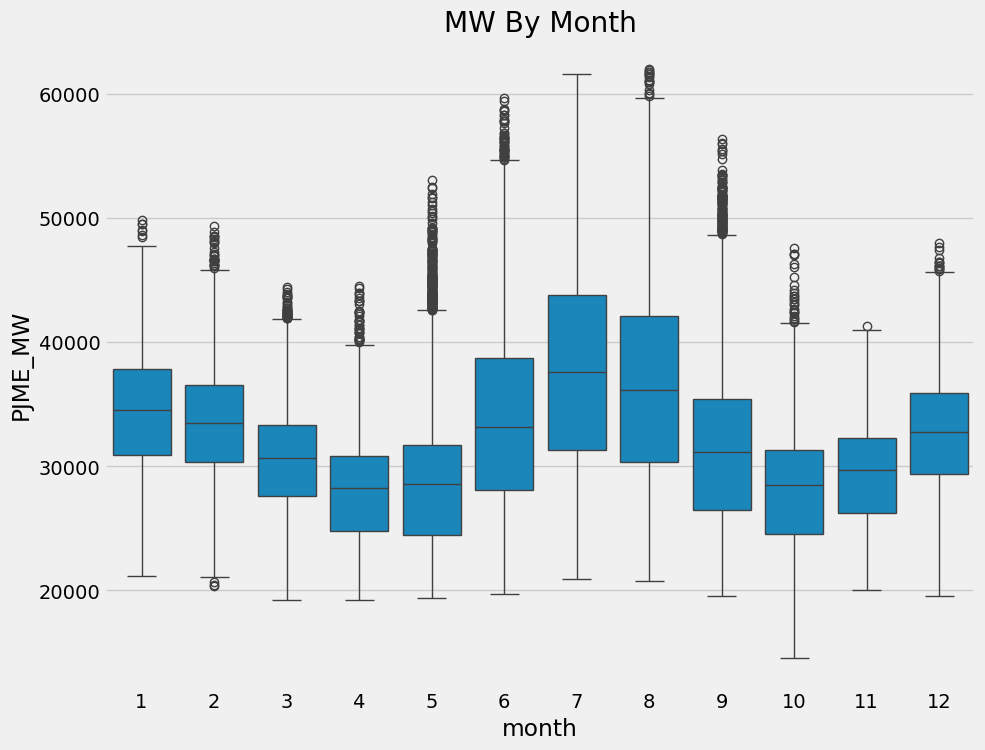

In [14]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.boxplot(data = df, x = 'month' , y = 'PJME_MW')
ax.set_title('MW By Month')
plt.show()

### Create our Model

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
train = create_features(train)
test = create_features(test)

In [17]:
df.columns

Index(['PJME_MW', 'hour', 'week', 'quarter', 'month', 'year', 'dayofyear'], dtype='object')

In [18]:
FEATURES = ['hour', 'week', 'quarter', 'month', 'year', 'dayofyear']
TARGET = ['PJME_MW']

In [19]:
X_TRAIN = train[FEATURES]
Y_TRAIN = train[TARGET]

In [20]:
X_Test = test[FEATURES]
Y_Test = test[TARGET]

In [21]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50,
                      learning_rate = 0.01)

In [22]:
reg.fit(X_TRAIN, Y_TRAIN, eval_set = [(X_TRAIN , Y_TRAIN), (X_Test, Y_Test)], 
       verbose = 100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.26089


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

### Feature Importance

In [23]:
fi = pd.DataFrame(data = reg.feature_importances_ , 
            index = reg.feature_names_in_,
            columns = ['importance'])

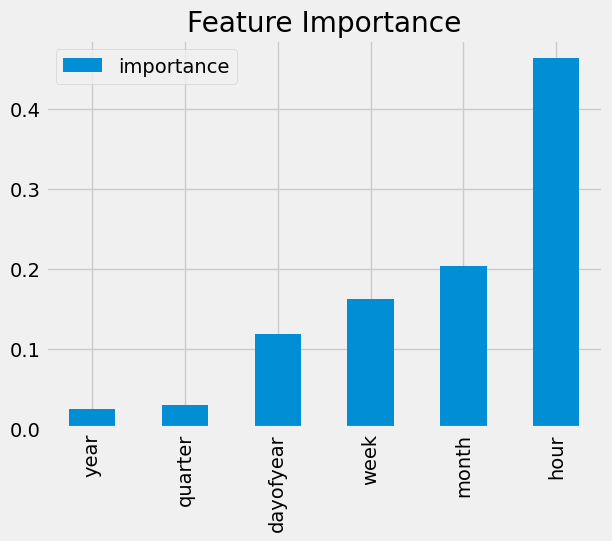

In [24]:
fi.sort_values('importance').plot(kind = 'bar', title = 'Feature Importance')
plt.show()

### Foecast on test

In [25]:
test['prediction'] = reg.predict(X_Test)

In [26]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

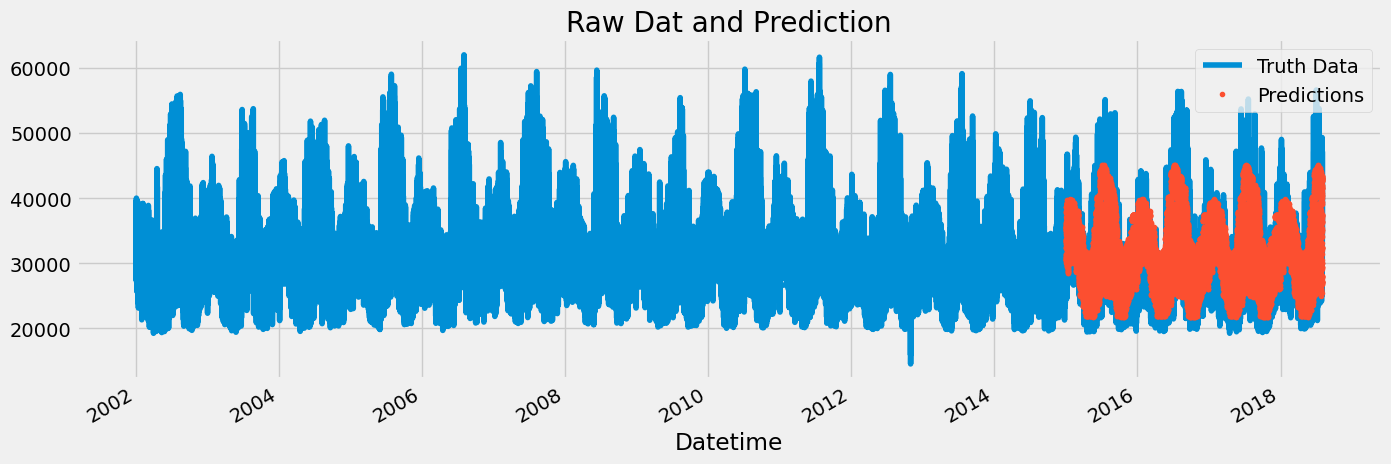

In [27]:
ax = df[['PJME_MW']].plot(figsize = (15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

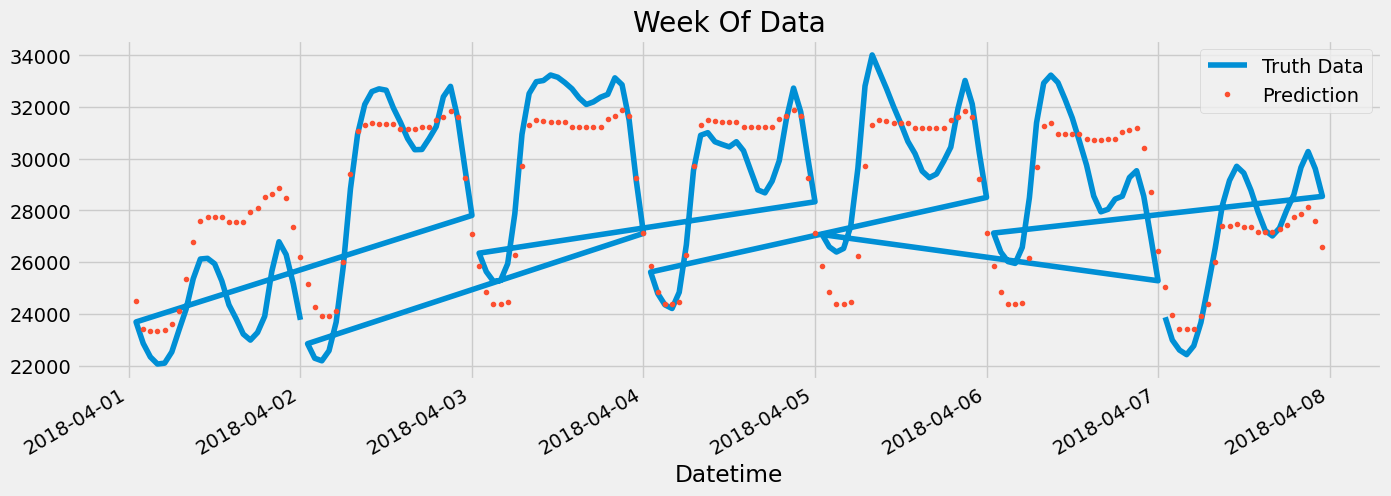

In [28]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [33]:
score = np.sqrt(mean_squared_error(test['PJME_MW'] , test['prediction']))
print(f"RMSE Score on Test set : {score: 0.2f}")

RMSE Score on Test set :  3741.03


### Calculate Error

In [ ]:
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)